In [140]:
import os
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE
from dotenv import load_dotenv

load_dotenv()
current_year = int(os.getenv('current_year'))

In [141]:
teams_df = pd.read_csv("processed_teams.csv")
games_df = pd.read_csv("processed_games.csv")
#scaled_points_df = pd.read_csv("scaled_points.csv")
fields_to_use = ['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'lucky_win', 'unlucky_loss', 'playoffSeed', 'scaled_moves', 'modified_wins']
#fields_to_use = [ 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'modified_wins']

In [142]:
teams_df = teams_df[['year', 'abbrev', 'id', 'record.overall.wins', 'record.overall.losses', 'record.overall.pointsFor', 'record.overall.pointsAgainst', 'scaled_pointsFor', 'scaled_pointsAgainst', 'itm', 'playoffSeed', 'scaled_moves', 'record.overall.streakLength' ]]
teams_df.rename(columns={'record.overall.wins': 'wins', 'record.overall.losses': 'losses', 'record.overall.pointsFor': 'pointsFor', 'record.overall.pointsAgainst': 'pointsAgainst'}, inplace=True)
teams_df.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,playoffSeed,scaled_moves,record.overall.streakLength
0,2012,SEX,1,9,4,1415.0,1270.0,0.564041,-0.776622,0.0,5,1.228248,2
1,2013,KAP!,1,9,4,1485.7,1382.0,0.187645,-1.375147,0.0,1,2.592722,1
2,2014,MK,1,5,8,1497.7,1590.7,0.070461,1.251402,0.0,9,1.647454,3
3,2015,JVB!,1,7,6,1490.8,1423.5,0.357305,-0.382989,0.0,4,1.980877,3
4,2016,BBC,1,9,4,1512.2,1266.7,0.510800,-1.944866,0.0,1,1.472703,2


In [143]:
sum_luck = games_df.groupby(['year', 'id']).agg({'unlucky_loss':'sum', 'lucky_win': 'sum'})
with_luck = teams_df.merge(sum_luck, left_on=['year', 'id'], right_on=['year', 'id'])
with_luck['modified_wins'] = with_luck['wins'] + with_luck['unlucky_loss'] - with_luck['lucky_win']
ml_df = with_luck
with_luck.loc[with_luck['year'] == current_year].head(12)

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,playoffSeed,scaled_moves,record.overall.streakLength,unlucky_loss,lucky_win,modified_wins
9,2021,Caw,1,8,6,2064.3,1765.6,1.210171,-0.909638,0.0,5,0.262878,1,1,0,9
19,2021,TOTY,2,7,7,1901.1,1934.5,0.281015,0.873910,0.0,8,0.602597,1,3,3,7
29,2021,Sith,3,5,9,1605.7,1791.6,-1.400804,-0.635083,0.0,9,-0.610686,2,1,6,0
39,2021,TMB,7,4,10,1588.3,1931.4,-1.499869,0.841175,0.0,11,-2.018094,6,1,4,1
49,2021,Mill,9,5,9,1622.7,1809.5,-1.304017,-0.446063,0.0,10,-0.465092,2,1,2,4
59,2021,BD,10,9,5,2029.1,1783.3,1.009765,-0.722729,1.0,3,1.184973,2,2,1,10
69,2021,Rock,12,7,7,1816.7,1842.4,-0.199505,-0.098646,0.0,6,-0.513623,1,2,2,7
79,2021,2021,13,10,4,1939.5,1683.2,0.499640,-1.779764,0.0,2,0.262878,1,1,3,8
89,2021,faq,15,7,7,1783.2,1859.3,-0.390232,0.079814,1.0,7,1.718817,2,0,4,3
99,2021,JJJ,16,3,11,1768.0,2047.2,-0.476772,2.063998,0.0,12,-1.047468,1,2,3,2


In [144]:
just_itm = ml_df[ml_df['year'] != current_year]
X = just_itm[fields_to_use]
y = just_itm['itm']

sm_over = SMOTE(random_state=10)
os_X, os_y = sm_over.fit_resample(X,  y)

X_train, X_test, y_train, y_test = train_test_split(os_X, os_y, test_size = 0.20)

In [145]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)

In [146]:
cur_teams = ml_df[ml_df['year'] == current_year]
X_cur = cur_teams[fields_to_use]

In [147]:
predictions = mlp.predict(X_test)

In [148]:
predictions

array([0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.])

In [149]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[11  5]
 [ 3 15]]
              precision    recall  f1-score   support

         0.0       0.79      0.69      0.73        16
         1.0       0.75      0.83      0.79        18

    accuracy                           0.76        34
   macro avg       0.77      0.76      0.76        34
weighted avg       0.77      0.76      0.76        34



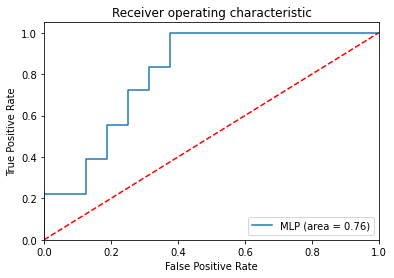

In [150]:
ml_roc_auc = roc_auc_score(y_test, mlp.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP (area = %0.2f)' % ml_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [151]:
cur_predictions = mlp.predict(X_cur)

In [152]:
cur_teams["pred_itm"] = cur_predictions
cur_teams[['id', 'abbrev', 'wins', 'losses', 'pred_itm']].head(12)

/tmp/ipykernel_10787/1077995852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_teams["pred_itm"] = cur_predictions


,id,abbrev,wins,losses,pred_itm
9,1,Caw,8,6,1.0
19,2,TOTY,7,7,0.0
29,3,Sith,5,9,0.0
39,7,TMB,4,10,0.0
49,9,Mill,5,9,0.0
59,10,BD,9,5,1.0
69,12,Rock,7,7,0.0
79,13,2021,10,4,0.0
89,15,faq,7,7,0.0
99,16,JJJ,3,11,0.0


In [153]:
prob_predict = mlp.predict_proba(X_cur)
for i in range(len(X_cur)):
	print("X=%s, Predicted=%.2f" % (X_cur.values[i], prob_predict[i][1]))

X=[ 8.          6.          1.21017147 -0.90963767  0.          1.
  5.          0.26287797  9.        ], Predicted=1.00
X=[7.         7.         0.28101484 0.87391039 3.         3.
 8.         0.60259719 7.        ], Predicted=0.00
X=[ 5.          9.         -1.4008042  -0.6350832   6.          1.
  9.         -0.61068574  0.        ], Predicted=0.00
X=[ 4.         10.         -1.49986869  0.84117505  4.          1.
 11.         -2.01809395  1.        ], Predicted=0.00
X=[ 5.          9.         -1.30401705 -0.44606301  2.          1.
 10.         -0.46509179  4.        ], Predicted=0.00
X=[ 9.          5.          1.00976514 -0.72272944  1.          2.
  3.          1.184973   10.        ], Predicted=1.00
X=[ 7.          7.         -0.19950488 -0.09864601  2.          2.
  6.         -0.51362311  7.        ], Predicted=0.00
X=[10.          4.          0.49963993 -1.77976414  3.          1.
  2.          0.26287797  8.        ], Predicted=0.00
X=[ 7.          7.         -0.3902325   0